AJ Notebook: Tanzania water problem
Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints


In [1]:
#imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
labels = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
#dataset with the ys of training data
df = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
#dataset with training set


In [3]:
df.shape #comparing shapes to see how it was divided.

(59400, 40)

In [4]:
labels.shape #looking at the y

(59400, 2)

Based on these 2 shapes you can see that the data was originally 74,250 rows and was divided into: 20% testing data, 80% training

In [5]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
df.loc[df['id'] != labels['id']] #always equal

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [8]:
full_df = df.merge(labels)
full_df.shape

(59400, 41)

In [9]:
full_df.loc[full_df['id'] == 69572] #checking accurate merge with a few things

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [10]:
full_df['status_group'].value_counts() #looking at the classes of the y

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

Changing the y classes to be 2 classes instead of three. Grouping by functional and non functional. Functional but needs repair now going to be functional. 

In [11]:
full_df['status'] = np.where(full_df['status_group'] == "functional needs repair", 
                                'functional', full_df['status_group'])

In [12]:
full_df['status'].value_counts() #checking the column grouped correctly
#no class imbalance currently

functional        36576
non functional    22824
Name: status, dtype: int64

In [13]:
#creating binary grouping
full_df['binary_status'] = np.where(full_df['status'] == 'functional', 1, 0)

In [14]:
full_df['binary_status'].value_counts()

1    36576
0    22824
Name: binary_status, dtype: int64

In [15]:
full_df.isna().sum() #noting lots of NAs in some of these columns

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [16]:
full_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status,binary_status
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,functional,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,functional,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,functional,1
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,non functional,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,functional,1


In [17]:
full_df['scheme_management'].value_counts() #going to drop this since lots of other groupings and "company" or private operater

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [18]:

clean_df = full_df.drop(['status', 'status_group', 'waterpoint_type', 'source', 'payment_type', 
              'date_recorded', 'water_quality', 'quantity', 'num_private', 
                         'management_group', 'extraction_type_group', 
                         'extraction_type', 'recorded_by', 'latitude',
                        'longitude', 'lga', 'ward', 'scheme_name',
                        'region', 'subvillage', 'basin', 'wpt_name', 'public_meeting',
                        'gps_height', 'scheme_management'], axis = 1)

In [19]:
clean_df.head(10)

,id,amount_tsh,funder,installer,region_code,district_code,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,binary_status
0,69572,6000.0,Roman,Roman,11,5,109,False,1999,gravity,vwc,pay annually,good,enough,spring,groundwater,communal standpipe,1
1,8776,0.0,Grumeti,GRUMETI,20,2,280,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,1
2,34310,25.0,Lottery Club,World vision,21,4,250,True,2009,gravity,vwc,pay per bucket,good,enough,dam,surface,communal standpipe,1
3,67743,0.0,Unicef,UNICEF,90,63,58,True,1986,submersible,vwc,never pay,good,dry,borehole,groundwater,communal standpipe,0
4,19728,0.0,Action In A,Artisan,18,1,0,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,1
5,9944,20.0,Mkinga Distric Coun,DWE,4,8,1,True,2009,submersible,vwc,pay per bucket,salty,enough,other,unknown,communal standpipe,1
6,19816,0.0,Dwsp,DWSP,17,3,0,True,0,handpump,vwc,never pay,good,enough,borehole,groundwater,hand pump,0
7,54551,0.0,Rwssp,DWE,17,3,0,True,0,handpump,wug,unknown,milky,enough,shallow well,groundwater,hand pump,0
8,53934,0.0,Wateraid,Water Aid,14,6,0,True,0,handpump,vwc,never pay,salty,seasonal,borehole,groundwater,hand pump,0
9,46144,0.0,Isingiro Ho,Artisan,18,1,0,True,0,handpump,vwc,never pay,good,enough,shallow well,groundwater,hand pump,1


In [20]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   funder                 55765 non-null  object 
 3   installer              55745 non-null  object 
 4   region_code            59400 non-null  int64  
 5   district_code          59400 non-null  int64  
 6   population             59400 non-null  int64  
 7   permit                 56344 non-null  object 
 8   construction_year      59400 non-null  int64  
 9   extraction_type_class  59400 non-null  object 
 10  management             59400 non-null  object 
 11  payment                59400 non-null  object 
 12  quality_group          59400 non-null  object 
 13  quantity_group         59400 non-null  object 
 14  source_type            59400 non-null  object 
 15  so

In [21]:
clean_df['region_code']= clean_df['region_code'].astype(str)
clean_df['district_code'] = clean_df['district_code'].astype(str)
clean_df['construction_year'] = clean_df['construction_year'].astype(str)
clean_df['amount_tsh'] = clean_df['amount_tsh'].astype(int)
clean_df['permit'] = np.where(clean_df['permit'] == True, 1, clean_df['permit'])
clean_df['permit'] = np.where(clean_df['permit'] == False, 0, clean_df['permit'])
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     59400 non-null  int64 
 1   amount_tsh             59400 non-null  int64 
 2   funder                 55765 non-null  object
 3   installer              55745 non-null  object
 4   region_code            59400 non-null  object
 5   district_code          59400 non-null  object
 6   population             59400 non-null  int64 
 7   permit                 56344 non-null  object
 8   construction_year      59400 non-null  object
 9   extraction_type_class  59400 non-null  object
 10  management             59400 non-null  object
 11  payment                59400 non-null  object
 12  quality_group          59400 non-null  object
 13  quantity_group         59400 non-null  object
 14  source_type            59400 non-null  object
 15  source_class       

In [22]:
clean_df['permit'].value_counts()

1    38852
0    17492
Name: permit, dtype: int64

In [23]:
clean_df.info() #going to drop rows without waterpoint permit information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     59400 non-null  int64 
 1   amount_tsh             59400 non-null  int64 
 2   funder                 55765 non-null  object
 3   installer              55745 non-null  object
 4   region_code            59400 non-null  object
 5   district_code          59400 non-null  object
 6   population             59400 non-null  int64 
 7   permit                 56344 non-null  object
 8   construction_year      59400 non-null  object
 9   extraction_type_class  59400 non-null  object
 10  management             59400 non-null  object
 11  payment                59400 non-null  object
 12  quality_group          59400 non-null  object
 13  quantity_group         59400 non-null  object
 14  source_type            59400 non-null  object
 15  source_class       

In [24]:
clean_df.loc[((clean_df['permit'] != 0) &
             (clean_df['permit'] != 1))]


,id,amount_tsh,funder,installer,region_code,district_code,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,binary_status
43,19282,0,NaN,NaN,13,2,1,NaN,1980,motorpump,vwc,unknown,unknown,dry,borehole,groundwater,communal standpipe,0
47,13620,0,NaN,NaN,12,4,0,NaN,0,gravity,vwc,never pay,good,enough,spring,groundwater,communal standpipe,1
65,51072,0,NaN,NaN,13,2,1,NaN,1970,motorpump,vwc,unknown,unknown,dry,borehole,groundwater,communal standpipe,0
109,7116,0,NaN,NaN,12,4,0,NaN,0,other,vwc,never pay,good,enough,river/lake,surface,communal standpipe,1
118,10837,0,Hesawa,Hesawa,20,2,600,NaN,1997,gravity,other,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59339,1209,0,NaN,NaN,12,4,0,NaN,0,gravity,vwc,never pay,good,insufficient,spring,groundwater,communal standpipe,1
59344,6450,0,NaN,NaN,2,7,230,NaN,0,gravity,unknown,unknown,unknown,unknown,spring,groundwater,communal standpipe,1
59357,46563,0,NaN,NaN,13,2,1,NaN,1980,handpump,vwc,unknown,unknown,dry,shallow well,groundwater,hand pump,0
59366,55232,0,NaN,NaN,13,2,200,NaN,2000,handpump,vwc,never pay,good,insufficient,shallow well,groundwater,hand pump,1


In [25]:
clean_df.drop(clean_df[(clean_df['permit'] != 0) & 
                       (clean_df['permit'] != 1)].index, inplace=True)
clean_df['permit'] = clean_df['permit'].astype(int)

In [26]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56344 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     56344 non-null  int64 
 1   amount_tsh             56344 non-null  int64 
 2   funder                 55127 non-null  object
 3   installer              55102 non-null  object
 4   region_code            56344 non-null  object
 5   district_code          56344 non-null  object
 6   population             56344 non-null  int64 
 7   permit                 56344 non-null  int64 
 8   construction_year      56344 non-null  object
 9   extraction_type_class  56344 non-null  object
 10  management             56344 non-null  object
 11  payment                56344 non-null  object
 12  quality_group          56344 non-null  object
 13  quantity_group         56344 non-null  object
 14  source_type            56344 non-null  object
 15  source_class       

In [27]:
clean_df['funder'].value_counts()

Government Of Tanzania           9043
Danida                           3112
Hesawa                           2027
Rwssp                            1372
World Bank                       1345
                                 ... 
Isnashia And                        1
Cpps Mission                        1
Domestic Rural Development Pr       1
Chacha                              1
Bhws                                1
Name: funder, Length: 1835, dtype: int64

In [28]:
clean_df['installer'].value_counts()

DWE             17361
Government       1788
RWE              1203
Commu            1060
DANIDA           1049
                ...  
Nu                  1
Mgaya Masese        1
LEI                 1
Gerald              1
Jumuhia             1
Name: installer, Length: 2056, dtype: int64

In [29]:
clean_df.loc[clean_df['installer'] == '-'] #noticing construction year 0

,id,amount_tsh,funder,installer,region_code,district_code,population,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,binary_status
10217,42616,0,Kalebejo Parish,-,19,5,0,1,0,handpump,private operator,never pay,salty,insufficient,shallow well,groundwater,hand pump,1
20968,10873,0,Government Of Tanzania,-,19,5,0,1,0,other,vwc,pay per bucket,good,enough,river/lake,surface,communal standpipe,0
25769,21336,0,Government Of Tanzania,-,19,5,0,1,0,other,vwc,pay per bucket,good,enough,river/lake,surface,communal standpipe,1


In [30]:
clean_df['construction_year'].value_counts() #dropping this column since most years are blank! 

0       19580
2008     2576
2009     2491
2010     2430
2000     1566
2007     1559
2006     1447
2003     1276
2011     1211
2004     1109
2002     1065
1978     1027
2012     1026
2005      985
1995      979
1999      954
1985      943
1998      924
1984      779
1996      768
1982      741
1972      705
1994      703
1974      676
1990      667
1980      647
1992      632
1997      613
1993      595
2001      533
1988      521
1983      487
1975      437
1986      433
1976      411
1991      323
1989      316
1970      310
1987      301
1981      238
1977      199
1979      192
1973      183
2013      173
1971      145
1967       86
1963       85
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: construction_year, dtype: int64

In [31]:
clean_df.drop(['construction_year'], axis = 1, inplace = True)

In [32]:
clean_df['source_type'].value_counts() #keeping this. Pretty clean! 

shallow well            16253
spring                  15981
borehole                11162
river/lake              10013
rainwater harvesting     2039
dam                       630
other                     266
Name: source_type, dtype: int64

In [33]:
clean_df['extraction_type_class'].value_counts() #keeping this. Pretty clean! 

gravity         25234
handpump        16048
other            6050
submersible      5854
motorpump        2704
rope pump         349
wind-powered      105
Name: extraction_type_class, dtype: int64

In [34]:
clean_df['permit'].value_counts() #1 means has permit now

1    38852
0    17492
Name: permit, dtype: int64

In [35]:
clean_df['management'].value_counts()

vwc                 38296
wug                  6340
water board          2830
wua                  2468
private operator     1893
parastatal           1595
water authority       825
other                 744
company               658
unknown               519
other - school         99
trust                  77
Name: management, dtype: int64

In [36]:
clean_df['payment'].value_counts() #what to do with unknown? bucket here? do we care about this? 

never pay                23776
pay per bucket            8700
pay monthly               8221
unknown                   7290
pay when scheme fails     3777
pay annually              3585
other                      995
Name: payment, dtype: int64

In [37]:
clean_df.drop(['payment'], axis=1, inplace = True)

In [38]:
clean_df['amount_tsh'].value_counts() #what does 0 mean here? drop? 

0         39015
500        3075
50         2340
1000       1445
20         1430
          ...  
138000        1
900           1
8500          1
60000         1
9             1
Name: amount_tsh, Length: 93, dtype: int64

In [39]:
clean_df.info() #need to find nulls for funder and installer

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56344 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     56344 non-null  int64 
 1   amount_tsh             56344 non-null  int64 
 2   funder                 55127 non-null  object
 3   installer              55102 non-null  object
 4   region_code            56344 non-null  object
 5   district_code          56344 non-null  object
 6   population             56344 non-null  int64 
 7   permit                 56344 non-null  int64 
 8   extraction_type_class  56344 non-null  object
 9   management             56344 non-null  object
 10  quality_group          56344 non-null  object
 11  quantity_group         56344 non-null  object
 12  source_type            56344 non-null  object
 13  source_class           56344 non-null  object
 14  waterpoint_type_group  56344 non-null  object
 15  binary_status      

In [40]:
clean_df['quality_group'].value_counts() #what to do with unknown

good        48416
salty        5035
unknown      1399
milky         801
colored       490
fluoride      203
Name: quality_group, dtype: int64

In [41]:
clean_df['quantity_group'].value_counts()

enough          31979
insufficient    13934
dry              5836
seasonal         3901
unknown           694
Name: quantity_group, dtype: int64

going to drop rows with unknown quantity or quality since believe they would be important indicators in health of well. Maybe can do a ranking of quantity and quality to to scale them. Assign to numbers? 

In [42]:
clean_df.drop(clean_df[(clean_df['quantity_group'] == 'unknown') |
             (clean_df['quality_group'] == 'unknown')].index, inplace=True)
clean_df.shape


(54744, 16)

In [43]:
clean_df['quantity_group'].value_counts()

enough          31851
insufficient    13830
dry              5202
seasonal         3861
Name: quantity_group, dtype: int64

In [44]:
clean_df['quality_group'].value_counts()

good        48246
salty        5007
milky         799
colored       489
fluoride      203
Name: quality_group, dtype: int64

In [45]:
clean_df.drop(clean_df[clean_df['funder'].isna()].index, inplace = True)
clean_df.drop(clean_df[clean_df['installer'].isna()].index, inplace = True)           


In [46]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53586 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     53586 non-null  int64 
 1   amount_tsh             53586 non-null  int64 
 2   funder                 53586 non-null  object
 3   installer              53586 non-null  object
 4   region_code            53586 non-null  object
 5   district_code          53586 non-null  object
 6   population             53586 non-null  int64 
 7   permit                 53586 non-null  int64 
 8   extraction_type_class  53586 non-null  object
 9   management             53586 non-null  object
 10  quality_group          53586 non-null  object
 11  quantity_group         53586 non-null  object
 12  source_type            53586 non-null  object
 13  source_class           53586 non-null  object
 14  waterpoint_type_group  53586 non-null  object
 15  binary_status      

In [47]:
clean_df.shape

(53586, 16)

In [48]:
clean_df.describe()

,id,amount_tsh,population,permit,binary_status
count,53586.000000,53586.000000,53586.000000,53586.000000,53586.000000
mean,37110.555462,332.560202,183.354925,0.695835,0.623502
std,21447.151503,2705.659488,469.718027,0.460057,0.484512
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18514.250000,0.000000,0.000000,0.000000,0.000000
50%,37070.500000,0.000000,40.000000,1.000000,1.000000
75%,55634.750000,30.000000,230.000000,1.000000,1.000000
max,74247.000000,250000.000000,30500.000000,1.000000,1.000000


<AxesSubplot:>

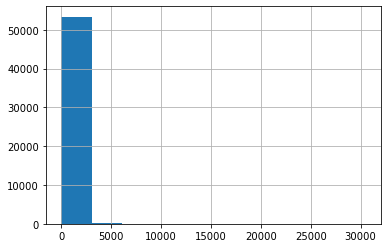

In [49]:
clean_df['population'].hist() #needs to be scaled? only for logistic or knn

<AxesSubplot:>

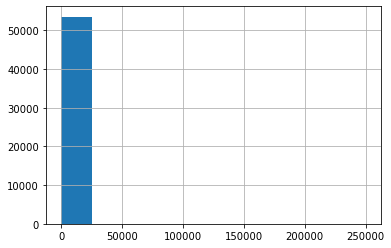

In [50]:
clean_df['amount_tsh'].hist() #needs to be scaled? only for logistic or knn

In [51]:
clean_df.corr() #almost all categorical

,id,amount_tsh,population,permit,binary_status
id,1.000000,-0.006130,-0.001574,0.000314,-0.001373
amount_tsh,-0.006130,1.000000,0.015299,0.030253,0.057345
population,-0.001574,0.015299,1.000000,-0.038569,0.011763
permit,0.000314,0.030253,-0.038569,1.000000,0.029007
binary_status,-0.001373,0.057345,0.011763,0.029007,1.000000


# Modeling!
### Dummy Model

In [52]:
X = clean_df.drop(['binary_status', 'id'], axis=1)
y = clean_df['binary_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#splitting 75/25

In [53]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dum_preds = dummy_model.predict(X_train)
log_loss(y_train, dum_preds) #makes sense

12.900882709722284

In [54]:
y_train.value_counts(normalize=True) #not a bad divide. Not incredible

1    0.62649
0    0.37351
Name: binary_status, dtype: float64

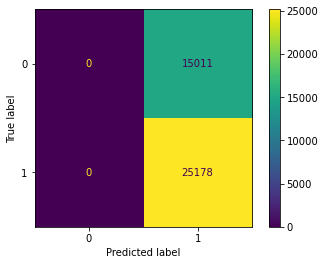

In [55]:
plot_confusion_matrix(dummy_model, X_train, y_train)

In [56]:
y_train.value_counts()

1    25178
0    15011
Name: binary_status, dtype: int64

In [129]:
15011/ (15011 + 25178) #percentage inbalanced 

0.3735101644728657

Check f1 score on dummy model

In [57]:
f1_score(y_train, dummy_model.predict(X_train)) 

0.7703581317790322

## Dealing with Categorical Variables and Scaling Numerics

In [58]:
X.dtypes #looking into data types of X 

amount_tsh                int64
funder                   object
installer                object
region_code              object
district_code            object
population                int64
permit                    int64
extraction_type_class    object
management               object
quality_group            object
quantity_group           object
source_type              object
source_class             object
waterpoint_type_group    object
dtype: object

In [59]:
scale = ['population', 'amount_tsh']
cat = ['funder', 'installer', 'region_code',
           'district_code', 'extraction_type_class', 'management', 'quality_group',
           'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

In [60]:
#creating subpipes to standard scale and one hot encode numeric and categorical columns respectively
subpipe_numeric = Pipeline(steps=[('ss', StandardScaler())])
subpipe_categorical = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown= 'ignore'))])

In [61]:
CT = ColumnTransformer(transformers=[('subpipe_numeric', subpipe_numeric, scale),
                                         ('subpipe_categorical', subpipe_categorical, cat)],
                           remainder='passthrough')

In [62]:
ct_transform = CT.fit_transform(X_train)

In [63]:
pd.DataFrame(ct_transform) #showing one hot encode!! 

,0,1,2,3,4,5,6,7,8,9,...,3407,3408,3409,3410,3411,3412,3413,3414,3415,3416
0,-0.383591,0.028459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.029582,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.548645,0.067755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.385668,-0.128724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40184,-0.383591,-0.050132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
40185,0.341020,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40186,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40187,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Showing all of my one hot encoded columns! So many. 

In [64]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

logreg_model= Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(random_state=42))])

In [65]:
logreg_model.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numeric',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['population', 'amount_tsh']),
                                                 ('subpipe_categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'region_code',
                                                   'district_code',
                                              

In [66]:
logreg_model.score(X_train, y_train) #accuracy score

0.8220159745203911

In [67]:
from sklearn.metrics import f1_score

f1_score(y_train, logreg_model.predict(X_train))

0.8670668475533831

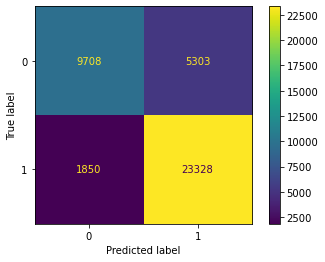

In [68]:
plot_confusion_matrix(logreg_model, X_train, y_train)

In [69]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring = 'f1')
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} f1 score
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [70]:
cv_results = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring = 'f1' ) 
#isnt running fully through

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [71]:
cv_results

array([0.86019905, 0.85861846, 0.85802411, 0.85980264, 0.86111368])

Decision Tree

In [72]:
decision_model = Pipeline(steps=[('ct', CT),
                            ('decision_tree', DecisionTreeClassifier(random_state=42))])

In [73]:
decision_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numeric',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['population', 'amount_tsh']),
                                                 ('subpipe_categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'region_code',
                                                   'district_code',
                                              

In [74]:
decision_model.score(X_train, y_train)

0.9360770360048769

In [75]:
f1_score(y_train, decision_model.predict(X_train)) #much closer to 1

0.9494201728652715

In [76]:
cv_decision = ModelWithCV(decision_model, 'decision_model', X_train, y_train)

In [77]:
cv_decision.print_cv_summary()

CV Results for `decision_model` model:
            0.85831 ± 0.00363 f1 score
        


Decision Model 2

In [78]:
decision_model2 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, max_depth=5 ))])

In [79]:
decision_model2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numeric',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['population', 'amount_tsh']),
                                                 ('subpipe_categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'region_code',
                                                   'district_code',
                                              

In [80]:
f1_score(y_train, decision_model2.predict(X_train)) ##went down a lot

0.8370890822381594

In [81]:
cv_decision = ModelWithCV(decision_model2, 'decision_model', X_train, y_train)

In [82]:
cv_decision.print_cv_summary() #much less overfit! but low score

CV Results for `decision_model` model:
            0.83801 ± 0.00481 f1 score
        


Decision Model 3

In [83]:
decision_model3 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, min_samples_split= 5))])
decision_model3.fit(X_train, y_train)
f1_score(y_train, decision_model3.predict(X_train)) ##went back up

0.9359062987615794

In [84]:
cv_decision = ModelWithCV(decision_model3, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary() #higher cv! 

CV Results for `decision_model` model:
            0.85673 ± 0.00321 f1 score
        


Decision Model 4

In [86]:
decision_model4 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, min_samples_split= 4))])
decision_model4.fit(X_train, y_train)
f1_score(y_train, decision_model4.predict(X_train)) ##went back up

0.9394214452030467

In [87]:
cv_decision = ModelWithCV(decision_model4, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `decision_model` model:
            0.85733 ± 0.00293 f1 score
        


Grid Search

tree = [{'decision_tree__max_depth': range(1, 10),
         'decision_tree__class_weight':['balanced', 'none'],
         'decision_tree__min_samples_split':range(1,5)}]
                                              
gs_pipe = GridSearchCV(
  estimator = decision_model, 
   param_grid = tree, cv=5, verbose=2, n_jobs=-3)
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [88]:
decision_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numeric',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['population', 'amount_tsh']),
                                                 ('subpipe_categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['funder', 'installer',
                                                   'region_code',
                                                   'district_code',
                                              

In [135]:
decision_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'decision_tree', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__subpipe_numeric', 'ct__subpipe_categorical', 'ct__subpipe_numeric__memory', 'ct__subpipe_numeric__steps', 'ct__subpipe_numeric__verbose', 'ct__subpipe_numeric__ss', 'ct__subpipe_numeric__ss__copy', 'ct__subpipe_numeric__ss__with_mean', 'ct__subpipe_numeric__ss__with_std', 'ct__subpipe_categorical__memory', 'ct__subpipe_categorical__steps', 'ct__subpipe_categorical__verbose', 'ct__subpipe_categorical__ohe', 'ct__subpipe_categorical__ohe__categories', 'ct__subpipe_categorical__ohe__drop', 'ct__subpipe_categorical__ohe__dtype', 'ct__subpipe_categorical__ohe__handle_unknown', 'ct__subpipe_categorical__ohe__sparse', 'decision_tree__ccp_alpha', 'decision_tree__class_weight', 'decision_tree__criterion', 'decision_tree__max_depth', 'decision_tree__max_features', 'decision_tree__max_leaf_nodes', 'decision_tree__

In [92]:
tree = {'decision_tree__max_depth': range(1, 10),
         'decision_tree__min_samples_split':range(1,5)}

maxdepth, min sample leaf
                                              
gs_pipe = GridSearchCV(
    estimator = decision_model, 
    param_grid = tree, cv=5, verbose=3, scoring = 'f1') 

#set for no n_jobs but otherwise -3 and see what happens

In [93]:
gs_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=1 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
Val

[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=2, score=0.815, total=   2.2s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=2, score=0.816, total=   1.7s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=2, score=0.815, total=   1.6s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=2, score=0.815, total=   2.1s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=1, decision_tree__min_samples_split=2, score=0.816, total=   1.7s
[CV] decision_tree__max_depth=1, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=1, score=nan, total=   0.6s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=1, score=nan, total=   0.6s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=1, score=nan, total=   0.6s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=2, score=0.836, total=   3.2s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=2, score=0.837, total=   3.2s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=2, score=0.836, total=   3.2s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=2, score=0.834, total=   3.2s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=2, decision_tree__min_samples_split=2, score=0.839, total=   3.2s
[CV] decision_tree__max_depth=2, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=1, score=nan, total=   0.6s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=1, score=nan, total=   0.6s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=1, score=nan, total=   0.6s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=2, score=0.838, total=   4.1s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=2, score=0.839, total=   4.2s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=2, score=0.836, total=   2.9s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=2, score=0.836, total=   4.1s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=3, decision_tree__min_samples_split=2, score=0.839, total=   4.1s
[CV] decision_tree__max_depth=3, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=1, score=nan, total=   0.6s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=2, score=0.838, total=   3.7s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=2, score=0.838, total=   4.5s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=2, score=0.840, total=   3.6s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=2, score=0.837, total=   4.3s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=4, decision_tree__min_samples_split=2, score=0.841, total=   4.9s
[CV] decision_tree__max_depth=4, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=2, score=0.840, total=   4.4s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=2, score=0.841, total=   5.6s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=2, score=0.834, total=   5.0s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=2, score=0.835, total=   4.3s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=5, decision_tree__min_samples_split=2, score=0.838, total=   5.6s
[CV] decision_tree__max_depth=5, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=2, score=0.844, total=   5.1s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=2, score=0.847, total=   4.7s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=2, score=0.837, total=   4.7s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=2, score=0.839, total=   5.1s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=6, decision_tree__min_samples_split=2, score=0.839, total=   4.6s
[CV] decision_tree__max_depth=6, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=1, score=nan, total=   0.7s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=2, score=0.850, total=   6.2s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=2, score=0.846, total=   4.8s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=2, score=0.846, total=   6.2s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=2, score=0.845, total=   6.3s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=7, decision_tree__min_samples_split=2, score=0.842, total=   6.0s
[CV] decision_tree__max_depth=7, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=1, score=nan, total=   0.9s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=1, score=nan, total=   0.9s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=1, score=nan, total=   0.9s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=2, score=0.854, total=   5.2s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=2, score=0.852, total=   4.9s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=2, score=0.848, total=   5.3s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=2, score=0.850, total=   6.7s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=8, decision_tree__min_samples_split=2, score=0.854, total=   4.9s
[CV] decision_tree__max_depth=8, decision_tree__min_samples_split

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=1, score=nan, total=   0.9s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=1, score=nan, total=   0.8s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=1, score=nan, total=   0.9s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=1 ..


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 228, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 

[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=1, score=nan, total=   0.9s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=2, score=0.858, total=   6.6s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=2, score=0.852, total=   6.1s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=2, score=0.859, total=   5.3s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=2, score=0.854, total=   6.5s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split=2 ..
[CV]  decision_tree__max_depth=9, decision_tree__min_samples_split=2, score=0.857, total=   5.1s
[CV] decision_tree__max_depth=9, decision_tree__min_samples_split

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 10.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numeric',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['population',
                                                                          'amount_tsh']),
                                                                        ('subpipe_categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                     

In [94]:
gs_pipe.best_params_

{'decision_tree__max_depth': 9, 'decision_tree__min_samples_split': 4}

In [95]:
decision_model5 = Pipeline(steps=[('ct', CT),
                            ('decision_tree', 
                             DecisionTreeClassifier(random_state=42, min_samples_split= 4,
                                                   max_depth = 9))])
decision_model5.fit(X_train, y_train)
f1_score(y_train, decision_model5.predict(X_train)) ##went back up

0.861718140766399

In [96]:
cv_decision = ModelWithCV(decision_model5, 'decision_model', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `decision_model` model:
            0.85655 ± 0.00461 f1 score
        


Random Forest

In [100]:
rf_model = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(max_features='sqrt',
                            max_samples=0.3,
                            random_state=1))])
rf_model.fit(X_train, y_train)
f1_score(y_train, rf_model.predict(X_train))

0.9229916685775433

In [102]:
cv_decision = ModelWithCV(rf_model, 'random_forest', X_train, y_train)
cv_decision.print_cv_summary() #better score!!!

CV Results for `random_forest` model:
            0.88094 ± 0.00417 f1 score
        


In [130]:
rf_model3 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(random_state=1))])
rf_model3.fit(X_train, y_train)
f1_score(y_train, rf_model3.predict(X_train))

0.949935715120583

In [131]:
cv_decision = ModelWithCV(rf_model3, 'random_forest', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `random_forest` model:
            0.87320 ± 0.00390 f1 score
        


Grid Search random Forest

In [103]:
rf_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'random_forest', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__subpipe_numeric', 'ct__subpipe_categorical', 'ct__subpipe_numeric__memory', 'ct__subpipe_numeric__steps', 'ct__subpipe_numeric__verbose', 'ct__subpipe_numeric__ss', 'ct__subpipe_numeric__ss__copy', 'ct__subpipe_numeric__ss__with_mean', 'ct__subpipe_numeric__ss__with_std', 'ct__subpipe_categorical__memory', 'ct__subpipe_categorical__steps', 'ct__subpipe_categorical__verbose', 'ct__subpipe_categorical__ohe', 'ct__subpipe_categorical__ohe__categories', 'ct__subpipe_categorical__ohe__drop', 'ct__subpipe_categorical__ohe__dtype', 'ct__subpipe_categorical__ohe__handle_unknown', 'ct__subpipe_categorical__ohe__sparse', 'random_forest__bootstrap', 'random_forest__ccp_alpha', 'random_forest__class_weight', 'random_forest__criterion', 'random_forest__max_depth', 'random_forest__max_features', 'random_forest__max_l

In [127]:
range(1,10)/10

SyntaxError: invalid syntax (<ipython-input-127-5e0f29f290aa>, line 1)

In [114]:
tree = {'random_forest__min_samples_split':range(1,5)}
                                              
gs_rf = GridSearchCV(
    estimator = rf_model, 
    param_grid = tree, cv=5, verbose=3, scoring = 'f1') 

In [115]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dis

[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=1, score=nan, total=   1.0s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/si

[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=1, score=nan, total=   0.7s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/si

[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=1, score=nan, total=   0.8s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/si

[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=1, score=nan, total=   0.8s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/si

[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=1, score=nan, total=   0.9s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=2 
[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=2, score=0.878, total=   4.5s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=2 
[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=2, score=0.876, total=   4.7s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=2 
[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=2, score=0.879, total=   4.4s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=2 
[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=2, score=0.876, total=   4.4s
[CV] random_forest__max_samples=0.1, random_forest__min_samples_split=2 
[CV]  random_forest__max_samples=0.1, random_forest__min_samples_split=2, score=0.876, total=   4.7s
[CV] random_forest__max_samples

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=1, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=1, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=1, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=1, score=nan, total=   0.8s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=1 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=1, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=2 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=2, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=2 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=2, score=nan, total=   0.8s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=2 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=2, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=2 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=2, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=2 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=2, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=3 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=3, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=3 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=3, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=3 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=3, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=3 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=3, score=nan, total=   0.8s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=3 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=3, score=nan, total=   0.8s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=4 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=4, score=nan, total=   0.8s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=4 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=4, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=4 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=4, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=4 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=4, score=nan, total=   0.9s
[CV] random_forest__max_samples=1.0, random_forest__min_samples_split=4 


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 342, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in 

[CV]  random_forest__max_samples=1.0, random_forest__min_samples_split=4, score=nan, total=   0.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numeric',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['population',
                                                                          'amount_tsh']),
                                                                        ('subpipe_categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                     

In [116]:
gs_rf.best_params_

{'random_forest__max_samples': 0.1, 'random_forest__min_samples_split': 2}

In [120]:
rf_model2 = Pipeline(steps=[('ct', CT),
                            ('random_forest', RandomForestClassifier(max_features='sqrt',
                            max_samples=0.1,
                            random_state=1))])
rf_model2.fit(X_train, y_train)
f1_score(y_train, rf_model2.predict(X_train))

0.8978473434303624

In [121]:
cv_decision = ModelWithCV(rf_model2, 'random_forest', X_train, y_train)
cv_decision.print_cv_summary()

CV Results for `random_forest` model:
            0.87862 ± 0.00406 f1 score
        


## Final Model Predictions:
- Using the rf_model since it had the highest cross validation score

In [123]:
print('Training:',f1_score(y_train, rf_model.predict(X_train)))
print('Testing:', f1_score(y_test, rf_model.predict(X_test)))

Training: 0.9229916685775433
Testing: 0.8778155423699522


In [ ]:
#confusion model on testing data 

In [ ]:
#graphing feature importance in my model. Y is level or importance X is all my features. Graph the top 5 or 10 features 

In [182]:
len(rf_model['random_forest'].feature_importances_)



3417

In [141]:
rf_model['random_forest'].feature_names_

AttributeError: 'RandomForestClassifier' object has no attribute 'feature_names_'

In [146]:
pd.DataFrame(ct_transform) #this shows the one hot encode

,0,1,2,3,4,5,6,7,8,9,...,3407,3408,3409,3410,3411,3412,3413,3414,3415,3416
0,-0.383591,0.028459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.029582,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.548645,0.067755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.385668,-0.128724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40184,-0.383591,-0.050132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
40185,0.341020,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40186,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40187,-0.385668,-0.128724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [148]:
CT.get_feature_names()

AttributeError: Transformer subpipe_numeric (type Pipeline) does not provide get_feature_names.

In [152]:
CT.get_feature_names()

AttributeError: Transformer subpipe_numeric (type Pipeline) does not provide get_feature_names.

In [161]:
CT

ColumnTransformer(remainder='passthrough',
                  transformers=[('subpipe_numeric',
                                 Pipeline(steps=[('ss', StandardScaler())]),
                                 ['population', 'amount_tsh']),
                                ('subpipe_categorical',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['funder', 'installer', 'region_code',
                                  'district_code', 'extraction_type_class',
                                  'management', 'quality_group',
                                  'quantity_group', 'source_type',
                                  'source_class', 'waterpoint_type_group'])])

In [173]:
feature_names = ['population', 'amount_tsh']

In [175]:
ohe_feature_names = CT.named_transformers_['subpipe_categorical']['ohe'].get_feature_names().tolist()

In [176]:
feature_names.extend(ohe_feature_names)

In [187]:
feature_names.append('permit')

In [188]:
len(feature_names)

3417

In [190]:
feature_importance = []

for feature, fi, in zip(feature_names, rf_model['random_forest'].feature_importances_):
    feature_importance.append((feature,fi))

In [191]:
feature_importance

[('population', 0.1252657681861209),
 ('amount_tsh', 0.05422392073230461),
 ('x0_0', 0.0009400373092960017),
 ('x0_A/co Germany', 6.127171443895833e-05),
 ('x0_Aar', 8.308821061152564e-05),
 ('x0_Abas Ka', 9.33571512103183e-06),
 ('x0_Abasia', 8.952994451582443e-05),
 ('x0_Abc-ihushi Development Cent', 1.023592628003684e-05),
 ('x0_Abd', 1.9511088311991502e-05),
 ('x0_Abdala', 7.298392598648306e-06),
 ('x0_Abs', 7.70788811761743e-08),
 ('x0_Aco/germany', 1.7079224882194243e-05),
 ('x0_Acord', 2.659567701535803e-06),
 ('x0_Acra', 3.109673478995485e-05),
 ('x0_Action Aid', 1.4086535365665157e-05),
 ('x0_Action Contre La Faim', 6.73976527618865e-05),
 ('x0_Adap', 3.501636762867582e-05),
 ('x0_Adb', 0.0013824306365008302),
 ('x0_Adf', 0.00011510629166413998),
 ('x0_Adp', 0.0001007781144741417),
 ('x0_Adp Bungu', 1.4764898083163749e-05),
 ('x0_Adp Mombo', 0.00010158780177372123),
 ('x0_Adp/w', 1.4707852867608156e-05),
 ('x0_Adra', 0.0011696614731412922),
 ('x0_Af', 8.631262213967219e-05),
 

In [192]:
feature_importance.sort(key = lambda x: x[1], reverse = True)

In [196]:
feature_importance[:10]

[('population', 0.1252657681861209),
 ('x7_dry', 0.0834856189224012),
 ('amount_tsh', 0.05422392073230461),
 ('x7_enough', 0.04714161692855469),
 ('x10_other', 0.03296328059141029),
 ('x4_other', 0.029328269915258394),
 ('x7_insufficient', 0.023642106925771133),
 ('x4_handpump', 0.01574898785210494),
 ('x0_Government Of Tanzania', 0.014023722265299968),
 ('x4_gravity', 0.013739413159464184)]

#type of well - to distinguish between functional and non 
care about type of well a lot. 
x7 too - qunatity 
- amount tsh ... how does this help 
- predicting if functional. 
- If

In [197]:
clean_df['extraction_type_class'].value_counts()

gravity         24016
handpump        15405
submersible      5554
other            5535
motorpump        2628
rope pump         346
wind-powered      102
Name: extraction_type_class, dtype: int64

# Ignore below:

NameError: name 'feature_used' is not defined

In [139]:

importances = rf_model['random_forest'].feature_importances_
#std = np.std([rf_model.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title(" ")
ax.set_ylabel(" ")
fig.tight_layout()

NameError: name 'feature_names' is not defined

# Ignore all below

In [ ]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train, y=y_train)

In [ ]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax);

In [ ]:
log_pipe.print_cv_summary()